<font color="brown">
<div style="border:dotted brown 3px; padding: 20px">
    
***Описание проекта:***
    
    
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.  
    
Постройте модель, которая по фотографии определит приблизительный возраст человека.  
В вашем распоряжении набор фотографий людей с указанием возраста.



# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1/255.)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


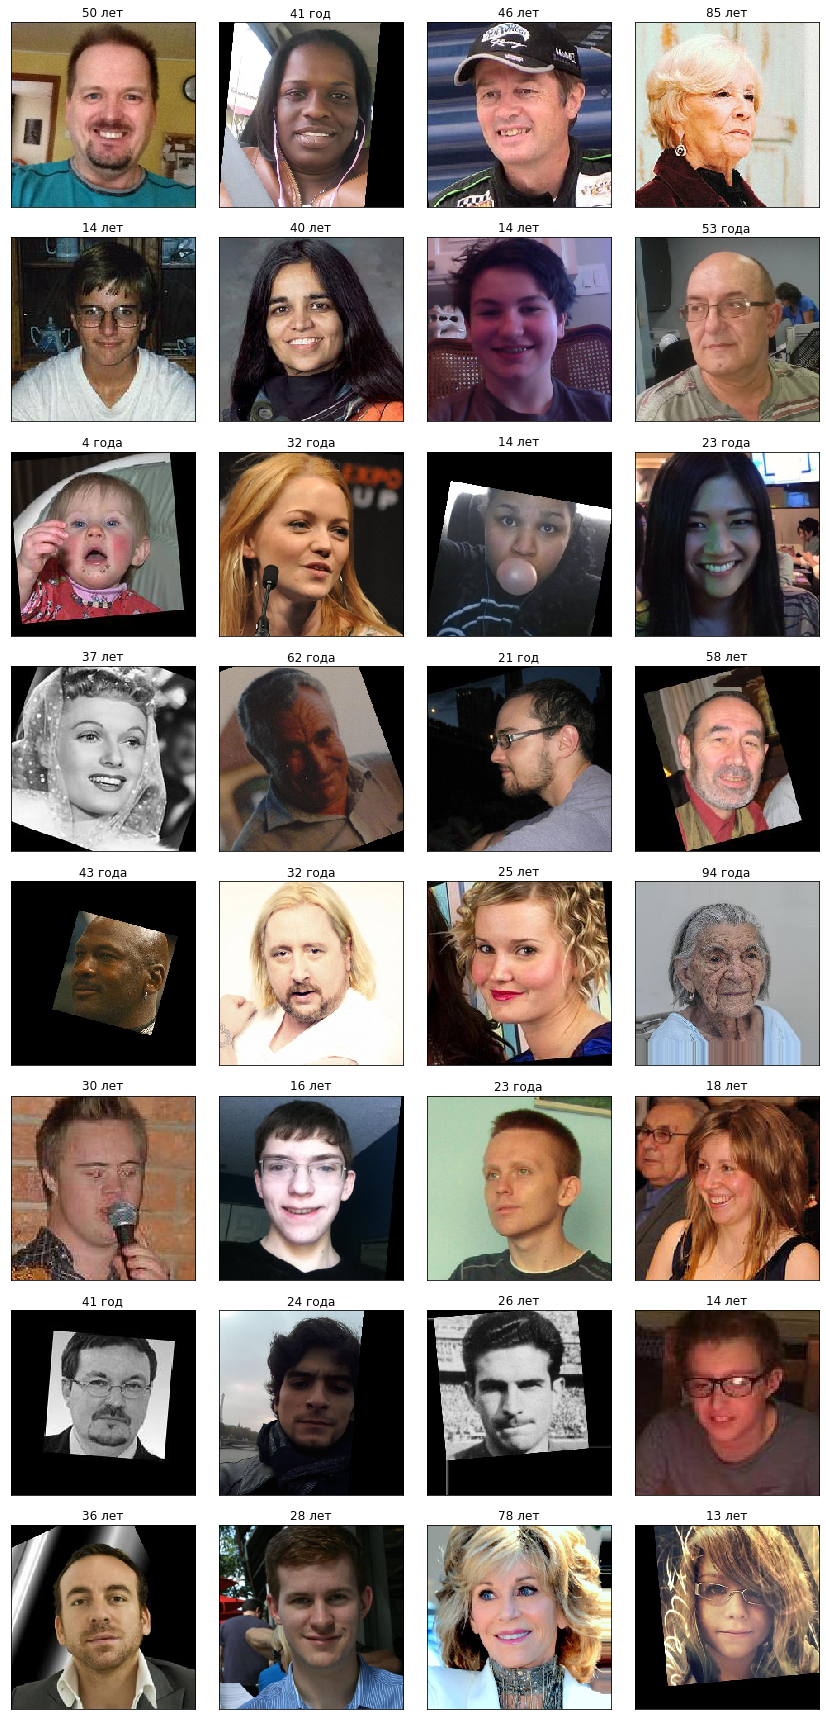

In [3]:
def create_a_title(age):
    res = str(age)
    if str(age).zfill(3)[-2] == '1' \
       or age%10 == 0 or age%10 > 4:
        return res+' лет'
    if age%10 >1:
        return res+' года'
    return res+' год'

features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,24))
for i in range(32):
    fig.add_subplot(8, 4, i+1)
    plt.title(create_a_title(target[i]))
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


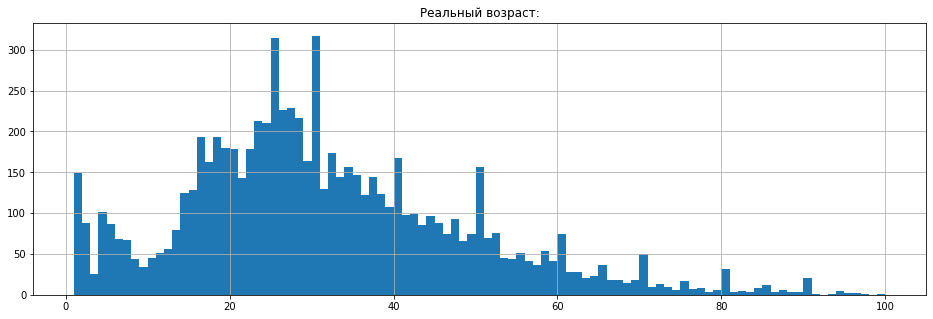

In [6]:
labels.hist(bins=99, figsize=(16,5))
plt.title('Реальный возраст:')
plt.show()

***Вывод:***
- Пропусков данных нет
- Возраст указан корректно
- Качество фотографий довольно сильно различается (масштаб, ракурс, посторонние предметы)

## Обучение модели

***Код обучения модели:***

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=321)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25,
                                            rescale=1. / 255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=321)

    return val_datagen_flow


def create_model(input_shape):
    optimazer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        #weights='imagenet',
                        include_top=False)

    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimazer, metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=20,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, epochs=epochs)

    return model
```

***Результат вывода на экран:***


```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2022-01-27 00:02:56.206853: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-27 00:02:56.496460: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 44s - loss: 228.8095 - mae: 10.7948 - val_loss: 753.7657 - val_mae: 22.5106
Epoch 2/20
178/178 - 37s - loss: 77.2168 - mae: 6.6065 - val_loss: 763.3082 - val_mae: 22.6196
Epoch 3/20
178/178 - 37s - loss: 54.6969 - mae: 5.6157 - val_loss: 246.8857 - val_mae: 12.4878
Epoch 4/20
178/178 - 37s - loss: 37.8938 - mae: 4.7039 - val_loss: 109.6213 - val_mae: 7.9120
Epoch 5/20
178/178 - 37s - loss: 28.4808 - mae: 4.0722 - val_loss: 77.3963 - val_mae: 6.6361
Epoch 6/20
178/178 - 37s - loss: 22.5211 - mae: 3.6346 - val_loss: 92.8619 - val_mae: 7.6922
Epoch 7/20
178/178 - 37s - loss: 19.2628 - mae: 3.3483 - val_loss: 68.8390 - val_mae: 6.2501
Epoch 8/20
178/178 - 37s - loss: 16.7094 - mae: 3.1491 - val_loss: 69.7081 - val_mae: 6.1869
Epoch 9/20
178/178 - 37s - loss: 14.1622 - mae: 2.8838 - val_loss: 67.2871 - val_mae: 6.2619
Epoch 10/20
178/178 - 37s - loss: 11.4596 - mae: 2.5921 - val_loss: 67.2836 - val_mae: 6.0485
Epoch 11/20
178/178 - 37s - loss: 9.1095 - mae: 2.2988 - val_loss: 63.6873 - val_mae: 5.9632
Epoch 12/20
178/178 - 37s - loss: 8.4469 - mae: 2.1832 - val_loss: 61.8574 - val_mae: 5.9035
Epoch 13/20
178/178 - 37s - loss: 7.2756 - mae: 2.0489 - val_loss: 60.5788 - val_mae: 5.8262
Epoch 14/20
178/178 - 37s - loss: 6.6340 - mae: 1.9404 - val_loss: 69.8337 - val_mae: 6.2268
Epoch 15/20
178/178 - 37s - loss: 6.7191 - mae: 1.9531 - val_loss: 62.7373 - val_mae: 6.0310
Epoch 16/20
178/178 - 37s - loss: 6.2655 - mae: 1.8894 - val_loss: 60.7782 - val_mae: 5.8108
Epoch 17/20
178/178 - 37s - loss: 7.1747 - mae: 2.0039 - val_loss: 63.5522 - val_mae: 6.0983
Epoch 18/20
178/178 - 37s - loss: 6.8959 - mae: 1.9680 - val_loss: 63.8006 - val_mae: 5.9642
Epoch 19/20
178/178 - 37s - loss: 6.2948 - mae: 1.9019 - val_loss: 57.9267 - val_mae: 5.6896
Epoch 20/20
178/178 - 37s - loss: 6.2925 - mae: 1.9032 - val_loss: 60.9994 - val_mae: 5.8974
WARNING:tensorflow:sample_weight modes were coerced from
  ...
  ['...']
    to  
60/60 - 9s - loss: 60.9994 - mae: 5.8974
Test MAE: 5.8974

```

## Анализ обученной модели

<button type="button" class="btn btn-primary">

#   Вывод:
- **Для обучения использована сеть ResNet50**
- **Время обучения 20 эпох составило менее 13 минут**
- **Удалось получить MAE менее 6 лет**